In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/green-future-data/companies.csv
/kaggle/input/green-future-data/energy_use.csv
/kaggle/input/green-future-data/emissions.csv
/kaggle/input/green-future-data/waste_management.csv


In [2]:
# Connect to SQLite database
conn = sqlite3.connect('green-future-data.db')

df_companies = pd.read_csv('/kaggle/input/green-future-data/companies.csv')
df_companies.to_sql('companies', conn, if_exists='replace', index=False)


df_emissions = pd.read_csv('/kaggle/input/green-future-data/emissions.csv')
df_emissions.to_sql('emissions', conn, if_exists='replace', index=False)

df_energy_use = pd.read_csv('/kaggle/input/green-future-data/energy_use.csv')
df_energy_use.to_sql('energy_use', conn, if_exists='replace', index=False)

df_waste_management = pd.read_csv('/kaggle/input/green-future-data/waste_management.csv')
df_waste_management.to_sql('waste_management', conn, if_exists='replace', index=False)


600

In [3]:
#Seeing if df has any missing data
df_companies.info()
df_emissions.info()
df_energy_use.info()
df_waste_management.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CompanyID    100 non-null    int64 
 1   CompanyName  100 non-null    object
 2   Sector       100 non-null    object
 3   Location     100 non-null    object
dtypes: int64(1), object(3)
memory usage: 3.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   EmissionID  600 non-null    int64  
 1   CompanyID   600 non-null    int64  
 2   Year        600 non-null    int64  
 3   CO2         600 non-null    float64
 4   CH4         600 non-null    float64
 5   N2O         600 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 28.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column   

In [4]:
print("Missing values in df_companies:")
print(df_companies.isna().sum())
print("Missing values in df_emissions:")
print(df_emissions.isna().sum())
print("Missing values in df_energy_use:")
print(df_energy_use.isna().sum())
print("Missing values in df_waste_management:")
print(df_waste_management.isna().sum())


Missing values in df_companies:
CompanyID      0
CompanyName    0
Sector         0
Location       0
dtype: int64
Missing values in df_emissions:
EmissionID    0
CompanyID     0
Year          0
CO2           0
CH4           0
N2O           0
dtype: int64
Missing values in df_energy_use:
EnergyID       0
CompanyID      0
Year           0
Electricity    0
FossilFuels    0
Renewables     0
dtype: int64
Missing values in df_waste_management:
WasteID           0
CompanyID         0
Year              0
RecycledWaste     0
LandfillWaste     0
CompostedWaste    0
dtype: int64


In [5]:
# There is no missing values. Lets continue with our analysis. SQL query
query = """
SELECT *
FROM companies
LIMIT 10;
"""

df_query_results = pd.read_sql_query(query, conn)
df_query_results


,CompanyID,CompanyName,Sector,Location
0,1,"Reid, Reilly and Martin",Energy,Christinafort
1,2,"Walker, Smith and White",Manufacturing,Lopezside
2,3,Jones LLC,Manufacturing,Lake Scott
3,4,King Ltd,Energy,Brandonchester
4,5,"Waters, Robinson and Obrien",Services,Robinsonshire
5,6,Brandt-Johnson,Services,North Juliaside
6,7,Kim LLC,Energy,West Noah
7,8,Barrett and Sons,Services,Lisaborough
8,9,Delgado-Johnson,Manufacturing,Nathanbury
9,10,Martin-Woods,Services,West Danielle


In [9]:
#Calculate total emissions (CO2, CH4, N2O) per year for all companies.
# The c and e under Select represent the Company dataset and the Emissions dataset 
query = """
SELECT
    c.CompanyID,
    c.CompanyName,
    e.Year,
    SUM(e.CO2) AS TotalCO2,
    SUM(e.CH4) AS TotalCH4,
    SUM(e.N2O) AS TotalN2O
FROM
    Companies c
INNER JOIN
    Emissions e ON c.CompanyID = e.CompanyID
GROUP BY
    c.CompanyID, c.CompanyName, e.Year
ORDER BY
    c.CompanyID, e.Year;
"""

result = pd.read_sql_query(query, conn) 
result


,CompanyID,CompanyName,Year,TotalCO2,TotalCH4,TotalN2O
0,1,"Reid, Reilly and Martin",2015,422.45,20.51,20.99
1,1,"Reid, Reilly and Martin",2016,192.63,31.92,11.64
2,1,"Reid, Reilly and Martin",2017,149.25,16.25,10.67
3,1,"Reid, Reilly and Martin",2018,484.50,32.83,12.45
4,1,"Reid, Reilly and Martin",2019,101.32,17.63,10.35
...,...,...,...,...,...,...
595,100,"Thomas, Cook and Phillips",2016,214.47,30.42,16.45
596,100,"Thomas, Cook and Phillips",2017,296.85,10.52,24.93
597,100,"Thomas, Cook and Phillips",2018,208.08,10.74,14.67
598,100,"Thomas, Cook and Phillips",2019,235.20,22.25,8.97


In [11]:
#If i wanted to narrow that down to the top 5 most polluting companies
query = """
SELECT
    c.CompanyID,
    c.CompanyName,
    SUM(e.CO2 + e.CH4 + e.N2O) AS TotalEmissions
FROM
    Companies c
INNER JOIN
    Emissions e ON c.CompanyID = e.CompanyID
GROUP BY
    c.CompanyID, c.CompanyName
ORDER BY
    TotalEmissions DESC
LIMIT 5;
"""

top_polluters = pd.read_sql_query(query, conn)

top_polluters

,CompanyID,CompanyName,TotalEmissions
0,72,"Graham, Greer and Hernandez",2613.35
1,63,Miller Ltd,2559.34
2,42,Hernandez-Torres,2446.73
3,7,Kim LLC,2440.37
4,11,Nichols-Brooks,2434.51


In [14]:
#Identify the top 5 companies with the highest CO2 emissions in the latest year available.
query = """
SELECT
    c.CompanyID,
    c.CompanyName,
    SUM(e.CO2) AS TotalCO2
FROM
    Companies c
INNER JOIN
    Emissions e ON c.CompanyID = e.CompanyID
GROUP BY
    c.CompanyID, c.CompanyName
ORDER BY
    TotalCO2 DESC
LIMIT 5;
"""

top_polluters = pd.read_sql_query(query, conn)


top_polluters


,CompanyID,CompanyName,TotalCO2
0,72,"Graham, Greer and Hernandez",2331.01
1,7,Kim LLC,2217.94
2,63,Miller Ltd,2213.36
3,42,Hernandez-Torres,2181.69
4,30,"Johnson, Woodard and Watson",2179.48


In [18]:
#Analyze trends in waste management practices over the years
query = """
SELECT
    Year,
    SUM(RecycledWaste) AS TotalRecycledWaste,
    SUM(LandfillWaste) AS TotalLandfillWaste,
    SUM(CompostedWaste) AS TotalCompostedWaste
FROM
    Waste_management
GROUP BY
    Year
ORDER BY
    Year
"""

waste_trends = pd.read_sql_query(query, conn)
print(waste_trends)



   Year  TotalRecycledWaste  TotalLandfillWaste  TotalCompostedWaste
0  2015            46237.93            55639.16             18327.41
1  2016            44246.58            54036.27             17581.81
2  2017            45667.64            59275.30             17016.87
3  2018            45600.65            50358.71             19067.38
4  2019            46219.45            56990.91             17563.55
5  2020            41463.88            56494.52             17184.78


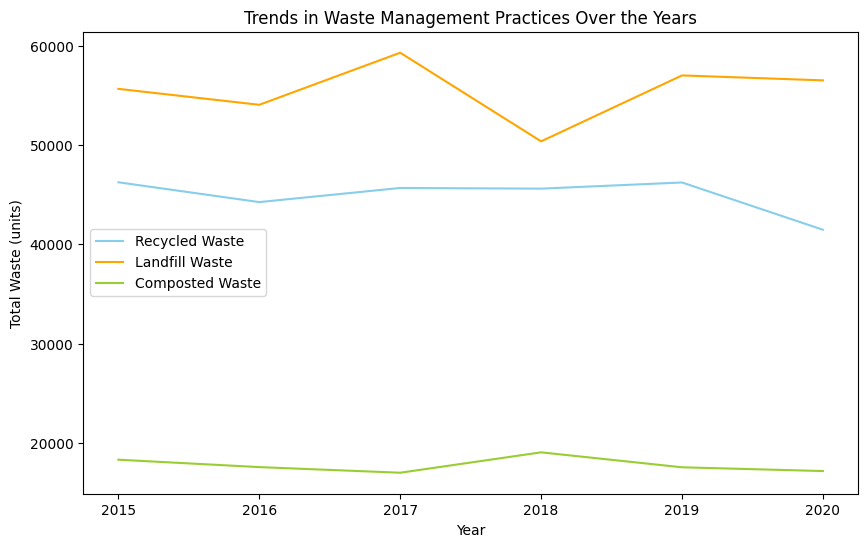

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(waste_trends['Year'], waste_trends['TotalRecycledWaste'], label='Recycled Waste', color='skyblue')
plt.plot(waste_trends['Year'], waste_trends['TotalLandfillWaste'], label='Landfill Waste', color='orange')
plt.plot(waste_trends['Year'], waste_trends['TotalCompostedWaste'], label='Composted Waste', color='yellowgreen')
plt.xlabel('Year')
plt.ylabel('Total Waste (units)')
plt.title('Trends in Waste Management Practices Over the Years')
plt.legend()
plt.show()




In [ ]:
#Increase Recycling Efforts:Since these companies are showing a decline in recycled waste over time, they should investigate 
#the causes and address these issues. Putting more robust recycling programs into place and partnering with local recycling
#facilities can enhance the efforts.